In [1]:
%%time
import pickle
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import glob
import os
from pathlib import Path

import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.io.shapereader import Reader
from cartopy.feature import ShapelyFeature
import matplotlib.ticker as mticker
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.ticker import FormatStrFormatter
states = ShapelyFeature(Reader('/glade/work/mazrooei/DATA/useful_shapefiles/states.shp').geometries(),
                                ccrs.PlateCarree(), facecolor='none', edgecolor='black')
proj = ccrs.Orthographic(central_longitude=-100, central_latitude=35)
ncproj = ccrs.PlateCarree()
# Define the projection of NWM
globe = ccrs.Globe(ellipse='sphere', semimajor_axis=6370000, semiminor_axis=6370000)
nwm_proj = ccrs.LambertConformal(globe=globe, central_longitude=-97.0, central_latitude=40.0, standard_parallels=(30.0,60.0))
extent_conus = [-122, -73, 22, 50]



CPU times: user 722 ms, sys: 191 ms, total: 913 ms
Wall time: 1.92 s


In [2]:
%%time
list_basins = pd.read_csv('/glade/u/home/mazrooei/work/USGS/usgs_ealstm/ealstm_regional_modeling/data/basin_list.txt', dtype=str, names=['site_no']).site_no.to_list()
LSTM_aorc_valid = pd.read_pickle('/glade/work/mazrooei/USGS/usgs_ealstm/ealstm_regional_modeling/runs/run_seed588170_aorc_gagesII_trained_on_2005_2020/ealstm_eval_2000_2005.p')
LSTM_c404_valid = pd.read_pickle('/glade/work/mazrooei/USGS/usgs_ealstm/ealstm_regional_modeling/runs/run_seed588170_c404_gagesII_trained_on_2005_2020/ealstm_eval_2000_2005.p')
LSTM_aorc_calib = pd.read_pickle('/glade/work/mazrooei/USGS/usgs_ealstm/ealstm_regional_modeling/runs/run_seed588170_aorc_gagesII_trained_on_2005_2020/ealstm_eval_2005_2020.p')
LSTM_c404_calib = pd.read_pickle('/glade/work/mazrooei/USGS/usgs_ealstm/ealstm_regional_modeling/runs/run_seed588170_c404_gagesII_trained_on_2005_2020/ealstm_eval_2005_2020.p')

usgs_meta = pd.read_csv("/glade/p/cisl/nwc/nwm_verification_obs/streamflow_usgs/obsStrMeta.csv", dtype={'site_no': str}, index_col=0).set_index('site_no')
usgs_meta = usgs_meta.sort_index()
usgs_short_columns = ['station_nm', 'dec_lat_va', 'dec_long_va']
usgs_short = usgs_meta[usgs_short_columns]



CPU times: user 2.04 s, sys: 129 ms, total: 2.17 s
Wall time: 2.35 s


In [3]:
def my_verif(obs, sim):
    # sim = df.qsim
    # obs = df.qobs
    if sim.notnull().sum() > 10:
        obs_mean = np.mean(obs)
        epsilon = 0.0001 * obs_mean
        obs_std = np.std(obs)
        obs_log = np.log(obs+epsilon)
        
        sim_mean = np.mean(sim)
        sim_std = np.std(sim)
        sim_log = np.log(sim+epsilon)

        Bias = sim_mean - obs_mean
        Err = sim-obs
        MSE = np.mean(Err**2)
        RMSE = np.sqrt(MSE)
        RRMSE = RMSE / obs_mean

        corr_pear = obs.corr(sim) 
        corr_rank = obs.corr(sim, method='spearman')

        if obs_std == 0:
            KGE_alpha = np.nan
            NSE_C = np.nan
        else:
            KGE_alpha = sim_std  / obs_std
            NSE_C = (Bias / obs_std)**2

        if obs_mean == 0:
            PBias = np.nan
            KGE_beta = np.nan
        else:
            PBias = 100*Bias / obs_mean
            KGE_beta  = sim_mean / obs_mean

        NSE_A = corr_pear**2
        NSE_B = (corr_pear - KGE_alpha)**2


        NSE = 1-( np.sum(Err**2) / np.sum((obs-obs_mean)**2) )
        KGE = 1-( np.sqrt( (corr_pear-1)**2 + (KGE_alpha-1)**2 + (KGE_beta-1)**2 ) )
        LogNSE = 1-( np.sum((sim_log-obs_log)**2) / np.sum((obs_log-np.mean(obs_log))**2))
        WtNSE = (0.5*NSE) + (0.5*LogNSE)

        # YILMAZ ET AL 2008
        n  = len(obs)
        
        m1 = .2
        m2 = .7
        sim_MS = sorted(sim, reverse=True)[round(n*m1):round(n*m2)]
        obs_MS = sorted(obs, reverse=True)[round(n*m1):round(n*m2)]
        QOm1 = obs_MS[0]
        QOm2 = obs_MS[-1]
        QSm1 = sim_MS[0]
        QSm2 = sim_MS[-1]
        #FDC midsegment slope bias
        PBias_FMS = 100*(((np.log(QSm1)-np.log(QSm2))-(np.log(QOm1)-np.log(QOm2)))/(np.log(QOm1)-np.log(QOm2))) 

        
        
        qH = 0.02 # high flow quantile
        sim_FH = sorted(sim, reverse=True)[:round(n*qH)]
        obs_FH = sorted(obs, reverse=True)[:round(n*qH)]
        #FDC high volume bias, top %2 flows
        PBias_FHV = 100*np.sum(np.subtract(sim_FH,obs_FH))/np.sum(obs_FH) 
        
        qL = 0.7 # Low flow quantile
        sim_FL = sorted(sim, reverse=True)[round(n*qL):]
        obs_FL = sorted(obs, reverse=True)[round(n*qL):]
        if (sim_FL[-1]==0 or obs_FL[-1]==0):
            epsilon2 = 0.0001 * np.min([np.mean(sim_FL), np.mean(obs_FL)])
            sim_FL = np.add(sim_FL, epsilon2)
            obs_FL = np.add(obs_FL, epsilon2)
#         ## FDC low volume bias, Low 30% flows YILMAZ ET AL 2008
#         S1 = np.sum(np.subtract(np.log(sim_FL),np.log(sim_FL[0])))
#         S2 = np.sum(np.subtract(np.log(obs_FL),np.log(obs_FL[0])))
#         PBias_FLV = -100 * (S1-S2)/(S2)
        min_FL = np.min([sim_FL, obs_FL]) ## Pokhrel et al 2008
        S1 = np.sum(np.subtract(np.log(sim_FL),np.log(min_FL)))
        S2 = np.sum(np.subtract(np.log(obs_FL),np.log(min_FL)))
        PBias_FLV = 100 * (S1-S2)/(S2)            
            
        out_df = pd.DataFrame({'mean_obs':obs_mean,
                               'mean_sim':sim_mean, 
                               'std_obs':obs_std,
                               'std_sim':sim_std, 
                               'Bias': Bias,
                               'PBias': PBias,
#                                'PBias_FMS': PBias_FMS,
                               'PBias_FLV': PBias_FLV,
                               'PBias_FHV': PBias_FHV,
                               'corr_pear': corr_pear,
                               'corr_rank': corr_rank,
                               'NSE': NSE,
                               'KGE': KGE,
                               'LogNSE': LogNSE,
                               'WtNSE': WtNSE,
                               'MSE': MSE,
                               'RMSE': RMSE,
                               'RRMSE': RRMSE,
                               'NSE_A':NSE_A, 
                               'NSE_B':NSE_B, 
                               'NSE_C':NSE_C, 
                               'KGE_alpha':KGE_alpha, 
                               'KGE_beta':KGE_beta
                               }, index=[0])
    else:
        out_df = pd.DataFrame({'mean_obs':np.NaN,
                               'mean_sim':np.NaN, 
                               'std_obs': np.NaN,
                               'std_sim': np.NaN, 
                               'Bias': np.NaN,
                               'PBias': np.NaN,
#                                'PBias_FMS': np.NaN,
                               'PBias_FLV': np.NaN,
                               'PBias_FHV': np.NaN,                              
                               'corr_pear': np.NaN,
                               'corr_rank': np.NaN,
                               'NSE': np.NaN,
                               'KGE': np.NaN,
                               'LogNSE': np.NaN,
                               'WtNSE': np.NaN,
                               'MSE': np.NaN,
                               'RMSE': np.NaN,
                               'RRMSE': np.NaN,
                               'NSE_A': np.NaN,
                               'NSE_B': np.NaN,
                               'NSE_C': np.NaN, 
                               'KGE_alpha': np.NaN,
                               'KGE_beta': np.NaN
                               }, index=[0])

    return out_df.round(4)



In [4]:
## Compute verif metrics for all sites
Metrics_aorc_valid = pd.DataFrame()
for s in tqdm(list_basins):
    df = LSTM_aorc_valid[s]
    verif = my_verif(df.qobs, df.qsim)
    verif.index = pd.Index([s], name='site_no') 
    Metrics_aorc_valid = Metrics_aorc_valid.append(verif)

Metrics_aorc_valid = usgs_short.loc[list_basins].join(Metrics_aorc_valid)
Metrics_aorc_valid = Metrics_aorc_valid.rename(columns={'Bias':'Bias [mm/day]'})

Metrics_c404_valid = pd.DataFrame()
for s in tqdm(list_basins):
    df = LSTM_c404_valid[s]
    verif = my_verif(df.qobs, df.qsim)
    verif.index = pd.Index([s], name='site_no') 
    Metrics_c404_valid = Metrics_c404_valid.append(verif)

Metrics_c404_valid = usgs_short.loc[list_basins].join(Metrics_c404_valid)
Metrics_c404_valid = Metrics_c404_valid.rename(columns={'Bias':'Bias [mm/day]'})


Metrics_aorc_calib = pd.DataFrame()
for s in tqdm(list_basins):
    df = LSTM_aorc_calib[s]
    verif = my_verif(df.qobs, df.qsim)
    verif.index = pd.Index([s], name='site_no') 
    Metrics_aorc_calib = Metrics_aorc_calib.append(verif)

Metrics_aorc_calib = usgs_short.loc[list_basins].join(Metrics_aorc_calib)
Metrics_aorc_calib = Metrics_aorc_calib.rename(columns={'Bias':'Bias [mm/day]'})

Metrics_c404_calib = pd.DataFrame()
for s in tqdm(list_basins):
    df = LSTM_c404_calib[s]
    verif = my_verif(df.qobs, df.qsim)
    verif.index = pd.Index([s], name='site_no') 
    Metrics_c404_calib = Metrics_c404_calib.append(verif)

Metrics_c404_calib = usgs_short.loc[list_basins].join(Metrics_c404_calib)
Metrics_c404_calib = Metrics_c404_calib.rename(columns={'Bias':'Bias [mm/day]'})


display(Metrics_aorc_valid)


  0%|          | 0/1291 [00:00<?, ?it/s]/glade/scratch/mazrooei/ipykernel_58267/3140294019.py:41: RuntimeWarning: invalid value encountered in double_scalars
  NSE = 1-( np.sum(Err**2) / np.sum((obs-obs_mean)**2) )
/glade/scratch/mazrooei/ipykernel_58267/3140294019.py:43: RuntimeWarning: invalid value encountered in double_scalars
  LogNSE = 1-( np.sum((sim_log-obs_log)**2) / np.sum((obs_log-np.mean(obs_log))**2))
  6%|▌         | 80/1291 [00:01<00:15, 77.17it/s]/glade/work/mazrooei/miniconda3/envs/myxr/lib/python3.9/site-packages/numpy/lib/function_base.py:2634: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/glade/work/mazrooei/miniconda3/envs/myxr/lib/python3.9/site-packages/numpy/lib/function_base.py:2493: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/glade/scratch/mazrooei/ipykernel_58267/3140294019.py:41: RuntimeWarning: divide by zero encountered in double_scalars
  NSE = 1-( np.sum(Err**2) / np.

station_nm  dec_lat_va  \
site_no                                                                   
01013500                   Fish River near Fort Kent, Maine   47.237500   
01021480                      Old Stream near Wesley, Maine   44.936944   
01027200  North Branch Penobscot River nr Pittston Farm, ME   45.935278   
01029200                Seboeis River near Shin Pond, Maine   46.143056   
01030500        Mattawamkeag River near Mattawamkeag, Maine   45.501111   
...                                                     ...         ...   
14318000                           LITTLE RIVER AT PEEL, OR   43.252618   
14325000            SOUTH FORK COQUILLE RIVER AT POWERS, OR   42.891499   
14362250                           STAR GULCH NEAR RUCH, OR   42.154014   
14375100  SUCKER CREEK BLW LITTLE GRAYBACK CK, NR HOLLAN...   42.159561   
14400000                    CHETCO RIVER NEAR BROOKINGS, OR   42.123443   

          dec_long_va  mean_obs  mean_sim  std_obs  std_sim  Bias [mm/day]  \
site_no                                                                      
01013500   -68.582778    1.5118    1.4221   1.8889   1.8753        -0.0898   
01021480   -67.736111    1.6550    1.7141   2.3425   2.3593         0.0591   
01027200   -69.993611    1.5904    1.8617   2.7083   3.2423         0.2713   
01029200   -68.633611    1.3594    1.4911   2.0812   2.2319         0.1318   
01030500   -68.305833    1.4703    1.5415   2.1520   2.2101         0.0712   
...               ...       ...       ...      ...      ...            ...   
14318000  -123.026172    1.8202    1.9974   2.8367   3.1725         0.1772   
14325000  -124.070652    3.2500    4.4680   5.7782   7.3448         1.2181   
14362250  -123.075323    0.2533    0.2427   0.7511   0.5112        -0.0106   
14375100  -123.478951       NaN    1.8296      NaN   2.2795            NaN   
14400000  -124.187311    6.3753    7.7136  10.8400  12.1227         1.3383   

            PBias  PBias_FLV  ...  LogNSE   WtNSE      MSE    RMSE   RRMSE  \
site_no                       ...                                            
01013500  -5.9381    27.3127  ...  0.7797  0.8323   0.4104  0.6406  0.4237   
01021480   3.5683    83.2571  ...  0.7273  0.7470   1.2810  1.1318  0.6839   
01027200  17.0552    29.0601  ...  0.6948  0.6572   2.7911  1.6707  1.0504   
01029200   9.6923    27.9744  ...  0.7382  0.7917   0.6706  0.8189  0.6024   
01030500   4.8442    45.1329  ...  0.7944  0.8466   0.4682  0.6843  0.4654   
...           ...        ...  ...     ...     ...      ...     ...     ...   
14318000   9.7373    26.1265  ...  0.9451  0.8517   1.9448  1.3946  0.7662   
14325000  37.4788    49.0073  ...  0.8882  0.7605  12.2632  3.5019  1.0775   
14362250  -4.1734   141.7685  ...  0.2434  0.4576   0.1852  0.4304  1.6990   
14375100      NaN        NaN  ...     NaN     NaN      NaN     NaN     NaN   
14400000  20.9927    19.9607  ...  0.9161  0.8857  17.0107  4.1244  0.6469   

           NSE_A   NSE_B   NSE_C  KGE_alpha  KGE_beta  
site_no                                                
01013500  0.8897  0.0025  0.0023     0.9928    0.9406  
01021480  0.7823  0.0151  0.0006     1.0071    1.0357  
01027200  0.7579  0.1067  0.0100     1.1972    1.1706  
01029200  0.8689  0.0197  0.0040     1.0724    1.0969  
01030500  0.9057  0.0057  0.0011     1.0270    1.0484  
...          ...     ...     ...        ...       ...  
14318000  0.8099  0.0477  0.0039     1.1184    1.0974  
14325000  0.8134  0.1363  0.0444     1.2711    1.3748  
14362250  0.6954  0.0235  0.0002     0.6806    0.9583  
14375100     NaN     NaN     NaN        NaN       NaN  
14400000  0.8994  0.0289  0.0152     1.1183    1.2099  

[1291 rows x 25 columns]

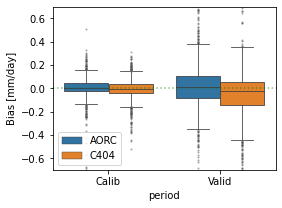

In [5]:
def boxplot_metric(metric_name, yrange=None, ylabel=None, best_value=None):
    flierprops = dict(marker='.', markerfacecolor=None, markersize=3,
                    linestyle='none', markeredgecolor='grey', alpha=.3)

    var1 = Metrics_aorc_calib[metric_name].to_frame()
    var1['model'] = 'AORC'
    var1['period'] = 'Calib'
    
    var2 = Metrics_aorc_valid[metric_name].to_frame()
    var2['model'] = 'AORC'
    var2['period'] = 'Valid'
    
    var3 = Metrics_c404_calib[metric_name].to_frame()
    var3['model'] = 'C404'
    var3['period'] = 'Calib'
   
    var4 = Metrics_c404_valid[metric_name].to_frame()
    var4['model'] = 'C404'
    var4['period'] = 'Valid'
    
    df = pd.concat([var1, var2, var3, var4], axis=0)

    plt.figure(figsize=(4,3))
    sns.boxplot(data=df, x='period', y=metric_name, hue='model', linewidth=.8, flierprops=flierprops)
    
    if best_value is not None:
        plt.axhline(y=best_value, ls=":", color='green', alpha=.5)
    
    if yrange:
        plt.ylim(yrange)
    
    if ylabel:
        plt.ylabel(ylabel)
    else:
        plt.ylabel(metric_name)
    
    
    plt.legend(loc='lower left')


boxplot_metric(metric_name='Bias [mm/day]', yrange=(-.7,.7), best_value=0)

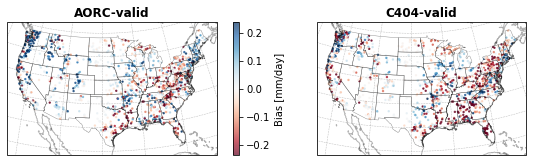

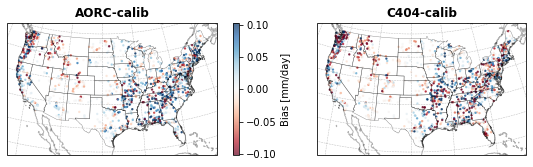

In [6]:
def mapplot_metric_valid(metric_name, cmap='jet', crange=None):
    df_aorc = Metrics_aorc_valid[['dec_long_va','dec_lat_va',metric_name]]
    df_c404 = Metrics_c404_valid[['dec_long_va','dec_lat_va',metric_name]]

    var = df_aorc[metric_name]
    if not crange:
        cmax = np.max([np.abs(var.quantile(.1)), np.abs(var.quantile(.9))])
        cmin = -1 * cmax
        crange = (cmin, cmax)

    cbar_kwargs=dict(orientation='horizontal', pad=0.1, aspect=30, shrink=0.6)
    fig = plt.figure(figsize=(11,8))
    gs1 = gridspec.GridSpec(1, 2)
    gs1.update(wspace=-0.05015, hspace=.25) # set the spacing between axes. 

    ax1 = plt.subplot(gs1[0],projection=proj)
    ax1.coastlines(edgecolor='gray', alpha=.3)
    ax1.add_feature(states, linewidth=.4, alpha=.5)
    s = df_aorc.plot.scatter(ax=ax1, x='dec_long_va', y='dec_lat_va', transform=ccrs.PlateCarree(), c=metric_name, 
                             s=2, vmin=crange[0], vmax=crange[1], cmap=cmap, alpha=.7)
#     print(s)
#     plt.colorbar(s)
    
    gl = ax1.gridlines(draw_labels=False, linewidth=.5, color='gray', alpha=0.5, linestyle='--')
#     gl.xlocator = mticker.FixedLocator([-120, -110, -100, -90, -80])
#     gl.right_labels = False
#     gl.top_labels = False
    ax1.set_title('AORC-valid', fontsize = 12, fontweight='bold')
    ax1.set_extent(extent_conus, crs=ccrs.PlateCarree())

    ax2 = plt.subplot(gs1[1],projection=proj)
    ax2.coastlines(edgecolor='gray', alpha=.3)
    ax2.add_feature(states, linewidth=.4, alpha=.5)
    img = df_c404.plot.scatter(ax=ax2, x='dec_long_va', y='dec_lat_va', transform=ccrs.PlateCarree(), c=metric_name, 
                         s=2, vmin=crange[0], vmax=crange[1], cmap=cmap, alpha=.7, colorbar=False)
    gl = ax2.gridlines(draw_labels=False, linewidth=.5, color='gray', alpha=0.5, linestyle='--')
#     gl.xlocator = mticker.FixedLocator([-120, -110, -100, -90, -80])
#     gl.right_labels = False
#     gl.top_labels = False
    ax2.set_title('C404-valid', fontsize = 12, fontweight='bold')
    ax2.set_extent(extent_conus, crs=ccrs.PlateCarree())
    
    fig.subplots_adjust(bottom=0.65)
    
#     plt.tight_layout()
#     cbar_ax = fig.add_axes([0.17, 0.17, 0.65, 0.04])
#     plt.colorbar(img, cax=cbar_ax, orientation="horizontal")



def mapplot_metric_calib(metric_name, cmap='jet', crange=None):
    df_aorc = Metrics_aorc_calib[['dec_long_va','dec_lat_va',metric_name]]
    df_c404 = Metrics_c404_calib[['dec_long_va','dec_lat_va',metric_name]]

    var = df_aorc[metric_name]
    if not crange:
        cmax = np.max([np.abs(var.quantile(.1)), np.abs(var.quantile(.9))])
        cmin = -1 * cmax
        crange = (cmin, cmax)

    cbar_kwargs=dict(orientation='horizontal', pad=0.1, aspect=30, shrink=0.6)
    fig = plt.figure(figsize=(11,8))
    gs1 = gridspec.GridSpec(1, 2)
    gs1.update(wspace=-0.05015, hspace=.25) # set the spacing between axes. 

    ax1 = plt.subplot(gs1[0],projection=proj)
    ax1.coastlines(edgecolor='gray', alpha=.3)
    ax1.add_feature(states, linewidth=.4, alpha=.5)
    s = df_aorc.plot.scatter(ax=ax1, x='dec_long_va', y='dec_lat_va', transform=ccrs.PlateCarree(), c=metric_name, 
                             s=2, vmin=crange[0], vmax=crange[1], cmap=cmap, alpha=.7)
#     print(s)
#     plt.colorbar(s)
    
    gl = ax1.gridlines(draw_labels=False, linewidth=.5, color='gray', alpha=0.5, linestyle='--')
#     gl.xlocator = mticker.FixedLocator([-120, -110, -100, -90, -80])
#     gl.right_labels = False
#     gl.top_labels = False
    ax1.set_title('AORC-calib', fontsize = 12, fontweight='bold')
    ax1.set_extent(extent_conus, crs=ccrs.PlateCarree())

    ax2 = plt.subplot(gs1[1],projection=proj)
    ax2.coastlines(edgecolor='gray', alpha=.3)
    ax2.add_feature(states, linewidth=.4, alpha=.5)
    img = df_c404.plot.scatter(ax=ax2, x='dec_long_va', y='dec_lat_va', transform=ccrs.PlateCarree(), c=metric_name, 
                         s=2, vmin=crange[0], vmax=crange[1], cmap=cmap, alpha=.7, colorbar=False)
    gl = ax2.gridlines(draw_labels=False, linewidth=.5, color='gray', alpha=0.5, linestyle='--')
#     gl.xlocator = mticker.FixedLocator([-120, -110, -100, -90, -80])
#     gl.right_labels = False
#     gl.top_labels = False
    ax2.set_title('C404-calib', fontsize = 12, fontweight='bold')
    ax2.set_extent(extent_conus, crs=ccrs.PlateCarree())
    
    fig.subplots_adjust(bottom=0.65)
 


mapplot_metric_valid(metric_name='Bias [mm/day]', cmap='RdBu')
mapplot_metric_calib(metric_name='Bias [mm/day]', cmap='RdBu')

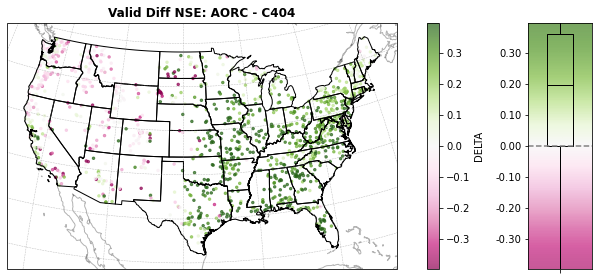

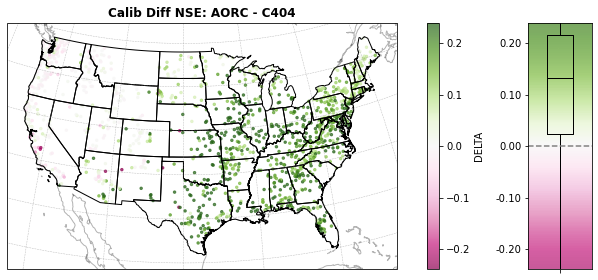

In [7]:
def mapDiffplot_metric_valid(metric_name, delta_abs=False):
    df_aorc = Metrics_aorc_valid[['dec_long_va','dec_lat_va',metric_name]]
    df_c404 = Metrics_c404_valid[['dec_long_va','dec_lat_va',metric_name]]

    #####
    delta = df_c404.drop(metric_name, 1)
    if delta_abs: #Positive delta always means aorc is better
        delta['DELTA'] = np.abs(df_c404[metric_name]) - np.abs(df_aorc[metric_name])
        delta_title = "Valid Diff "+metric_name+": |C404| - |AORC|"
    else:
        delta['DELTA'] = df_aorc[metric_name] - df_c404[metric_name]
        delta_title = "Valid Diff "+metric_name+": AORC - C404"

    var = delta['DELTA']
    cmax = np.max([np.abs(var.quantile(.2)), np.abs(var.quantile(.8))])
    cmin = -1 * cmax
    crange = (cmin, cmax)
    ymax = np.max([np.abs(var.quantile(.1)), np.abs(var.quantile(.9))])
    ymin = -1 * ymax
    yrange = (ymin, ymax)

    cbar_kwargs={'orientation':'horizontal', 'shrink':0.6, 'pad':-0.075, 'fraction':0.15, 'anchor':(0,.2)}
    flierprops = dict(marker='+', markerfacecolor=None, markersize=3,
                linestyle='none', markeredgecolor='grey')

    fig = plt.figure(figsize=(12,9))
    gs = gridspec.GridSpec(9, 9)
    # gs = gs.update(wspace=0.05, hspace=.005) # set the spacing between axes. 

    ax1 = fig.add_subplot(gs[:, 0:8], projection=proj)
    # ax1 = ax[0]
    # ax1 = plt.axes(projection=proj)
    ax1.coastlines(edgecolor='gray', alpha=.3)
    ax1.add_feature(states)
    img = delta.plot.scatter(ax=ax1, x='dec_long_va', y='dec_lat_va', transform=ccrs.PlateCarree(), c='DELTA', 
                         s=6, vmin=crange[0], vmax=crange[1], cmap="PiYG", alpha=.7)
    gl = ax1.gridlines(draw_labels=False, linewidth=.5, color='gray', alpha=0.5, linestyle='--')
#     gl.xlocator = mticker.FixedLocator([-120, -110, -100, -90, -80])
#     gl.right_labels = False
#     gl.top_labels = False
    ax1.set_title(delta_title, fontsize = 12, fontweight='bold')
    ax1.set_extent(extent_conus, crs=ccrs.PlateCarree())
    
    ax2 = fig.add_subplot(gs[:, 8])
    X = [[.6, .6], [.7, .7]]
    ax2.imshow(X, interpolation='bicubic', cmap=plt.cm.PiYG_r,
              extent=(0, 2, ymin, ymax), alpha=.7)
    
    plt.boxplot(var[var.notna()], widths=.8, flierprops=flierprops, medianprops=dict(color='k'), labels=[''])
    plt.ylim(crange)
    ax2.axhline(y=0, color='gray', linestyle='--')
    ax2.set_aspect('auto')
    ax2.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    # if ylabel:
    #     plt.ylabel(ylabel)
    # else:
    #     plt.ylabel(metric_name)
   
    fig.subplots_adjust(bottom=0.5)
 

def mapDiffplot_metric_calib(metric_name, delta_abs=False):
    df_aorc = Metrics_aorc_calib[['dec_long_va','dec_lat_va',metric_name]]
    df_c404 = Metrics_c404_calib[['dec_long_va','dec_lat_va',metric_name]]

    #####
    delta = df_c404.drop(metric_name, 1)
    if delta_abs: #Positive delta always means aorc is better
        delta['DELTA'] = np.abs(df_c404[metric_name]) - np.abs(df_aorc[metric_name])
        delta_title = "Calib Diff "+metric_name+": |C404| - |AORC|"
    else:
        delta['DELTA'] = df_aorc[metric_name] - df_c404[metric_name]
        delta_title = "Calib Diff "+metric_name+": AORC - C404"

    var = delta['DELTA']
    cmax = np.max([np.abs(var.quantile(.2)), np.abs(var.quantile(.8))])
    cmin = -1 * cmax
    crange = (cmin, cmax)
    ymax = np.max([np.abs(var.quantile(.1)), np.abs(var.quantile(.9))])
    ymin = -1 * ymax
    yrange = (ymin, ymax)

    cbar_kwargs=dict(orientation='horizontal', pad=0.1, aspect=30, shrink=0.6)
    flierprops = dict(marker='+', markerfacecolor=None, markersize=3,
                linestyle='none', markeredgecolor='grey')

    fig = plt.figure(figsize=(12,9))
    gs = gridspec.GridSpec(9, 9)
    # gs = gs.update(wspace=0.05, hspace=.005) # set the spacing between axes. 

    ax1 = fig.add_subplot(gs[:, 0:8], projection=proj)
    # ax1 = ax[0]
    # ax1 = plt.axes(projection=proj)
    ax1.coastlines(edgecolor='gray', alpha=.3)
    ax1.add_feature(states)
    img = delta.plot.scatter(ax=ax1, x='dec_long_va', y='dec_lat_va', transform=ccrs.PlateCarree(), c='DELTA', 
                         s=6, vmin=crange[0], vmax=crange[1], cmap="PiYG", alpha=.7)
    gl = ax1.gridlines(draw_labels=False, linewidth=.5, color='gray', alpha=0.5, linestyle='--')
#     gl.xlocator = mticker.FixedLocator([-120, -110, -100, -90, -80])
#     gl.right_labels = False
#     gl.top_labels = False
    ax1.set_title(delta_title, fontsize = 12, fontweight='bold')
    ax1.set_extent(extent_conus, crs=ccrs.PlateCarree())

    ax2 = fig.add_subplot(gs[:, 8])
    X = [[.6, .6], [.7, .7]]
    ax2.imshow(X, interpolation='bicubic', cmap=plt.cm.PiYG_r,
              extent=(0, 2, ymin, ymax), alpha=.7)
    
    plt.boxplot(var[var.notna()], widths=.8, flierprops=flierprops, medianprops=dict(color='k'), labels=[''])
    plt.ylim(crange)
    ax2.axhline(y=0, color='gray', linestyle='--')
    ax2.set_aspect('auto')
    ax2.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    # if ylabel:
    #     plt.ylabel(ylabel)
    # else:
    #     plt.ylabel(metric_name)
   
    fig.subplots_adjust(bottom=0.5)

    

mapDiffplot_metric_valid(metric_name='NSE', delta_abs=False)
mapDiffplot_metric_calib(metric_name='NSE', delta_abs=False)

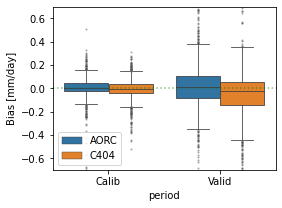

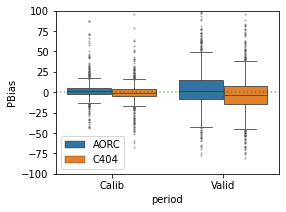

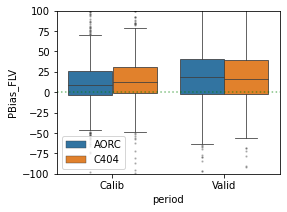

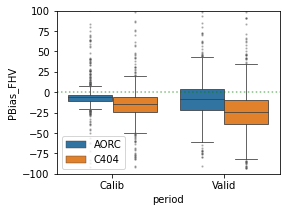

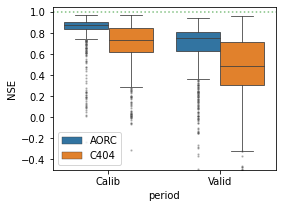

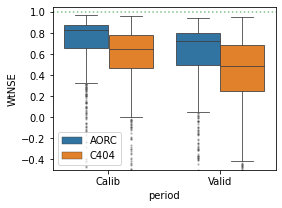

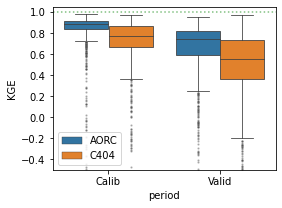

In [9]:
boxplot_metric('Bias [mm/day]', yrange=(-.7,.7), best_value=0)
boxplot_metric('PBias', yrange=(-100,100), best_value=0)
boxplot_metric('PBias_FLV', yrange=(-100,100), best_value=0)
boxplot_metric('PBias_FHV', yrange=(-100,100), best_value=0)
boxplot_metric('NSE', yrange=(-.5,1.05), best_value=1)
boxplot_metric('WtNSE', yrange=(-.5,1.05), best_value=1)
boxplot_metric('KGE', yrange=(-.5,1.05), best_value=1)

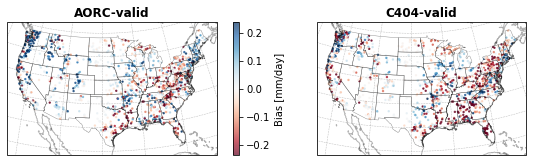

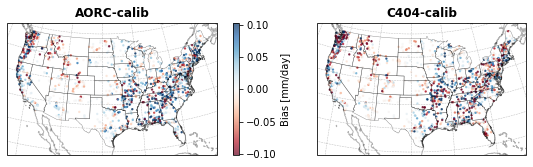

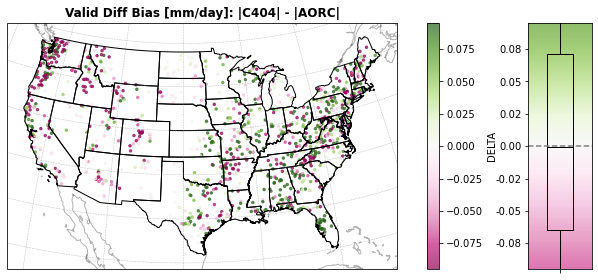

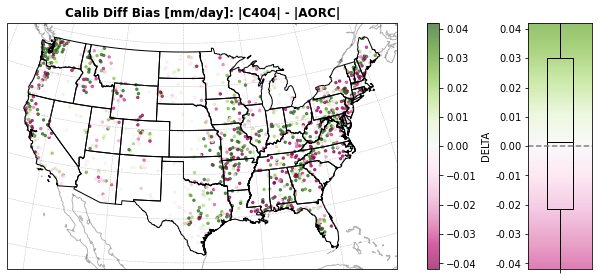

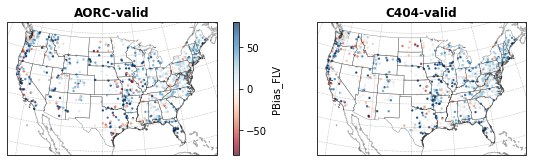

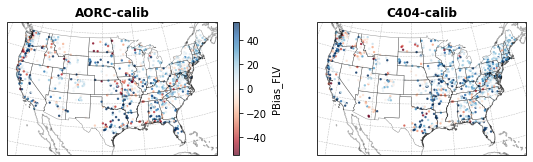

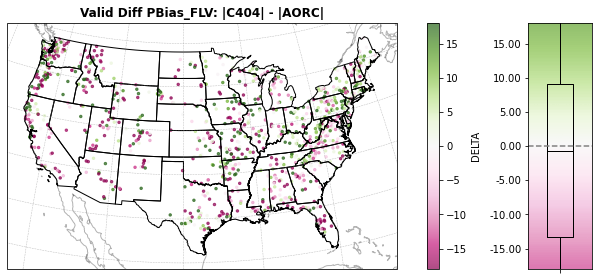

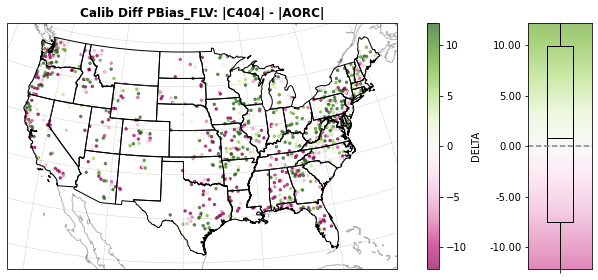

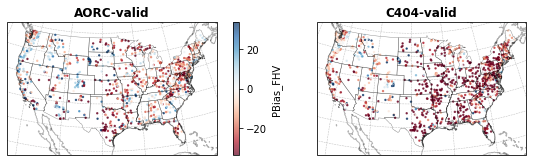

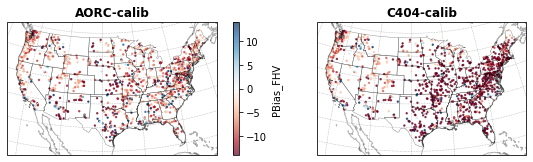

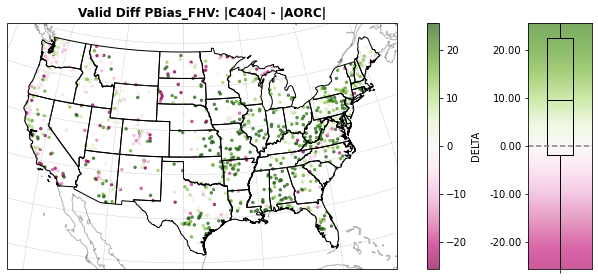

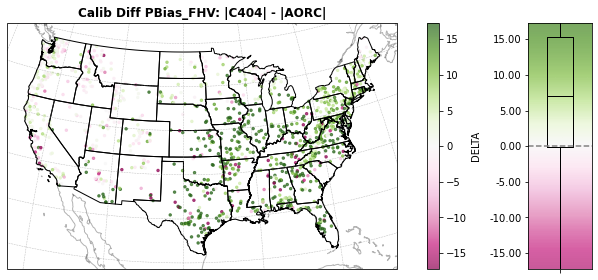

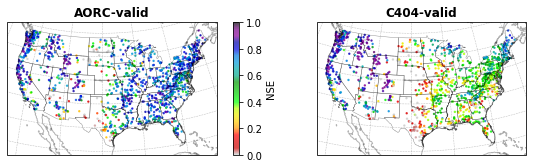

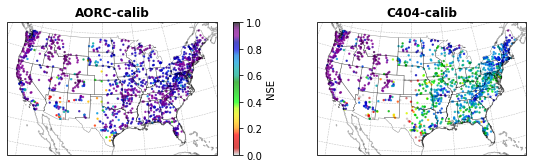

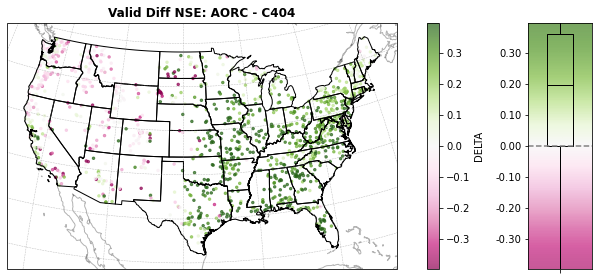

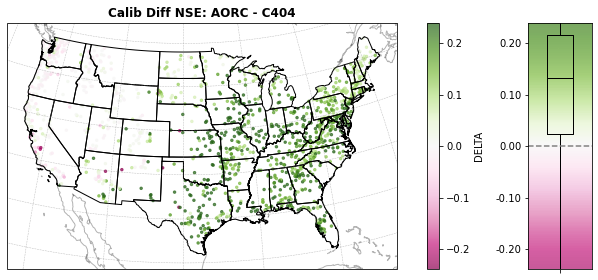

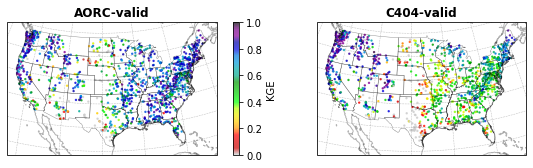

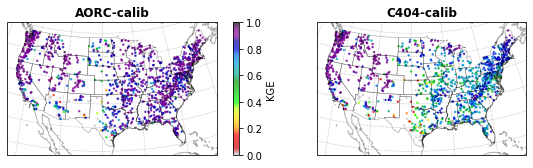

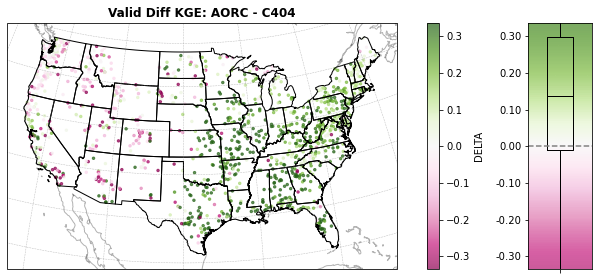

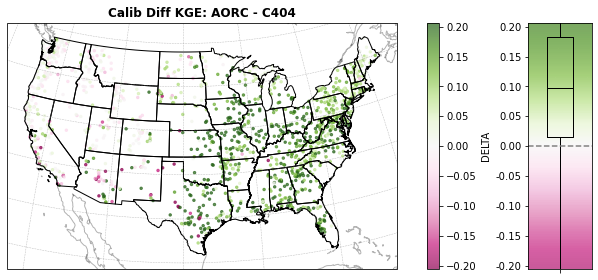

In [10]:
mapplot_metric_valid(metric_name='Bias [mm/day]', cmap='RdBu')
mapplot_metric_calib(metric_name='Bias [mm/day]', cmap='RdBu')
mapDiffplot_metric_valid(metric_name='Bias [mm/day]', delta_abs=True)
mapDiffplot_metric_calib(metric_name='Bias [mm/day]', delta_abs=True)


mapplot_metric_valid(metric_name='PBias_FLV', cmap='RdBu')
mapplot_metric_calib(metric_name='PBias_FLV', cmap='RdBu')
mapDiffplot_metric_valid(metric_name='PBias_FLV', delta_abs=True)
mapDiffplot_metric_calib(metric_name='PBias_FLV', delta_abs=True)


mapplot_metric_valid(metric_name='PBias_FHV', cmap='RdBu')
mapplot_metric_calib(metric_name='PBias_FHV', cmap='RdBu')
mapDiffplot_metric_valid(metric_name='PBias_FHV', delta_abs=True)
mapDiffplot_metric_calib(metric_name='PBias_FHV', delta_abs=True)


mapplot_metric_valid(metric_name='NSE', cmap='nipy_spectral_r', crange=(0,1))
mapplot_metric_calib(metric_name='NSE', cmap='nipy_spectral_r', crange=(0,1))
mapDiffplot_metric_valid(metric_name='NSE', delta_abs=False)
mapDiffplot_metric_calib(metric_name='NSE', delta_abs=False)


mapplot_metric_valid(metric_name='KGE', cmap='nipy_spectral_r', crange=(0,1))
mapplot_metric_calib(metric_name='KGE', cmap='nipy_spectral_r', crange=(0,1))
mapDiffplot_metric_valid(metric_name='KGE', delta_abs=False)
mapDiffplot_metric_calib(metric_name='KGE', delta_abs=False)

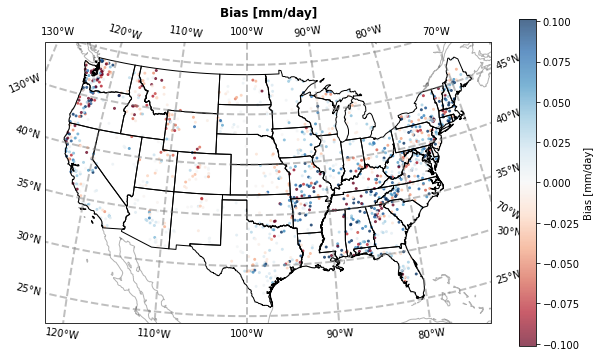

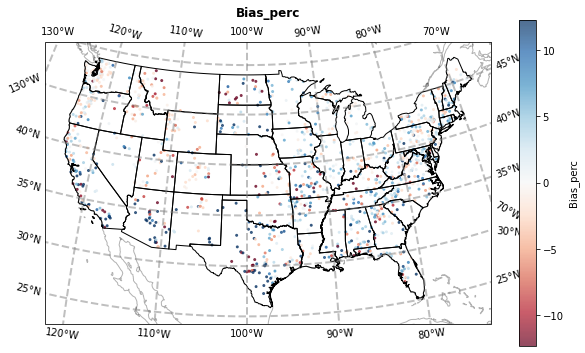

In [122]:
for varname in ['Bias [mm/day]', 'Bias_perc']:
    var = Metrics[varname]
    cmax = np.max([np.abs(var.quantile(.1)), np.abs(var.quantile(.9))])
    cmin = -1 * cmax
    fig = plt.figure(figsize=(10,6))
    gs1 = gridspec.GridSpec(1, 1)
    gs1.update(wspace=0.15, hspace=.25) # set the spacing between axes. 

    ax1 = plt.subplot(gs1[0],projection=proj)
    ax1.coastlines(edgecolor='gray', alpha=.3)
    ax1.add_feature(states)
    Metrics.plot.scatter(ax=ax1, x='dec_long_va', y='dec_lat_va', transform=ccrs.PlateCarree(), c=varname, 
                         s=4, vmin=cmin, vmax=cmax, cmap='RdBu', alpha=.7)
    # sc1 = ax1.scatter(Metrics.dec_long_va, Metrics.dec_lat_va, transform=ccrs.PlateCarree(), s=7, c=var, vmin=cmin, vmax=cmax, cmap='nipy_spectral_r')
    # plt.colorbar(sc1, orientation='vertical',ticklocation='auto')
    ax1.gridlines(draw_labels=True, linewidth=2, color='gray', alpha=0.5, linestyle='--')
    ax1.set_title(varname, fontsize = 12, fontweight='bold')
    ax1.set_extent(extent_conus, crs=ccrs.PlateCarree())

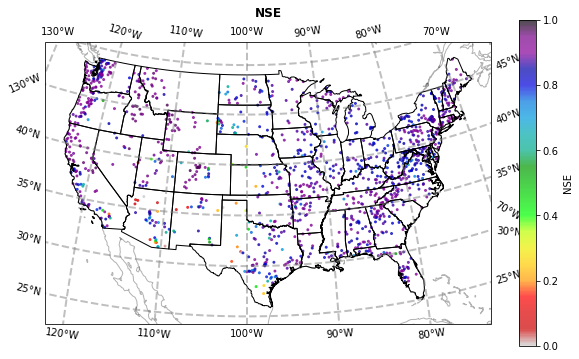

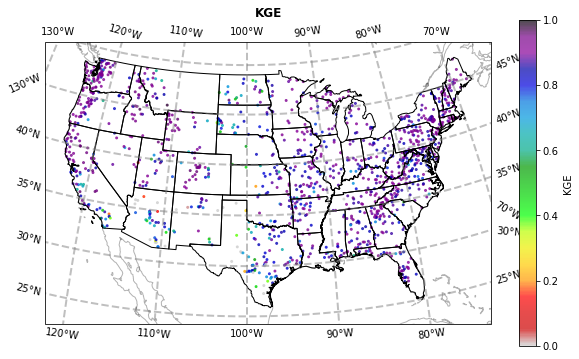

In [123]:
for varname in ['NSE', 'KGE']:
    var = Metrics[varname]
    cmin = 0
    cmax = 1
    fig = plt.figure(figsize=(10,6))
    gs1 = gridspec.GridSpec(1, 1)
    gs1.update(wspace=0.15, hspace=.25) # set the spacing between axes. 

    ax1 = plt.subplot(gs1[0],projection=proj)
    ax1.coastlines(edgecolor='gray', alpha=.3)
    ax1.add_feature(states)
    Metrics.plot.scatter(ax=ax1, x='dec_long_va', y='dec_lat_va', transform=ccrs.PlateCarree(), c=varname, 
                         s=4, vmin=cmin, vmax=cmax, cmap='nipy_spectral_r', alpha=.7)
    # sc1 = ax1.scatter(Metrics.dec_long_va, Metrics.dec_lat_va, transform=ccrs.PlateCarree(), s=7, c=var, vmin=cmin, vmax=cmax, cmap='nipy_spectral_r')
    # plt.colorbar(sc1, orientation='vertical',ticklocation='auto')
    ax1.gridlines(draw_labels=True, linewidth=2, color='gray', alpha=0.5, linestyle='--')
    ax1.set_title(varname, fontsize = 12, fontweight='bold')
    ax1.set_extent(extent_conus, crs=ccrs.PlateCarree())



### Hydrograph, single basin

In [28]:
Metrics_aorc.NSE.idxmax()

'13336500'

                qobs      qsim       err      %err
2000-10-01  2.007783  0.984894 -1.022889 -0.509462
2000-10-02  2.081823  1.208899 -0.872923 -0.419307
2000-10-03  1.085335  1.016721 -0.068615 -0.063220
2000-10-04  0.799106  0.724491 -0.074615 -0.093373
2000-10-05  0.675765  0.686517  0.010753  0.015912
...              ...       ...       ...       ...
2005-09-26  0.304347  0.373757  0.069410  0.228064
2005-09-27  0.278738  0.393964  0.115226  0.413386
2005-09-28  0.259400  0.383781  0.124380  0.479492
2005-09-29  0.248077  0.373807  0.125730  0.506820
2005-09-30  0.248599  0.394086  0.145486  0.585225

[1826 rows x 4 columns]


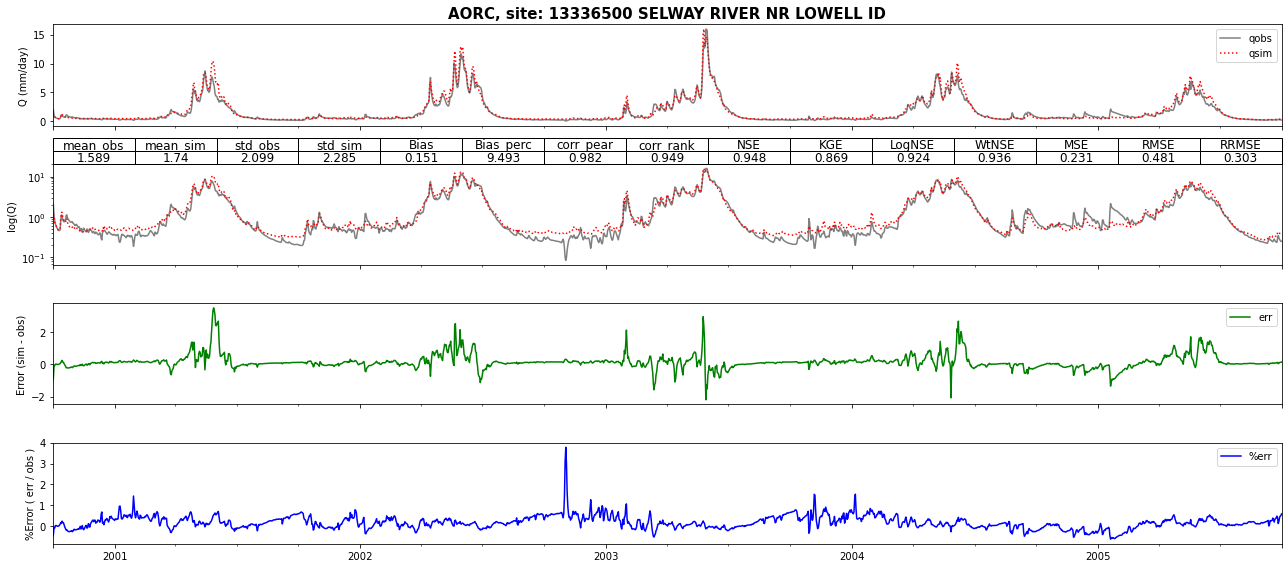

In [29]:
s = '13336500'
df = LSTM_aorc[s]
df['err'] = df.qsim - df.qobs
df['%err'] = df.err / df.qobs
verif = my_verif(df.qobs, df.qsim).iloc[:, :15]
print(df)
fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(18,8))
df.plot.line(ax=axes[0], use_index=True, sharex=True,  y=['qobs','qsim'], color={"qobs":"gray", 'qsim':'red'}, style=['-',':'], logy=False).legend(loc='upper right')
df.plot.line(ax=axes[1], y=['qobs','qsim'], color={"qobs":"gray", 'qsim':'red'}, style=['-',':'], logy=True, legend=False)
df.plot.line(ax=axes[2], y=['err'], color={"err":"green"}, style=['-'], legend=True).legend(loc='upper right')
df.plot.line(ax=axes[3], y=['%err'], color={"%err":"blue"}, style=['-'], legend=True).legend(loc='upper right')
axes[0].set_ylabel('Q (mm/day)')
axes[1].set_ylabel('log(Q)')
axes[2].set_ylabel('Error (sim - obs)')
axes[3].set_ylabel('%Error ( err / obs )')
axes[1].set_xlabel('Date')
axes[0].set_title('AORC, site: '+s+' '+usgs_short.station_nm.loc[s], fontsize=15, fontweight='bold')
# axes[3].axis('off')

tbl = axes[1].table(cellText=verif.values.round(3), colLabels=list(verif.columns), loc='top', cellLoc='center' ) #pd.plotting.table(ax=axes[3], data=verif.iloc[:, :10], fontsize=47)
tbl.auto_set_font_size(False)
tbl.set_fontsize(12)
plt.tight_layout()

In [17]:
diff = Metrics_aorc.NSE - Metrics_c404.NSE
diff[Metrics_c404.NSE>0].nlargest(20) #  idxmin()

site_no
08152900    0.7522
08400000    0.7283
08104900    0.7007
08408500    0.6808
08131400    0.6742
08186500    0.6726
07325860    0.6570
06893500    0.6478
08405105    0.6435
06853800    0.5876
09447800    0.5739
08086212    0.5709
02465493    0.5701
05494300    0.5671
06803510    0.5646
09485000    0.5460
06891810    0.5337
06803530    0.5273
08079600    0.5055
09484000    0.4925
Name: NSE, dtype: float64

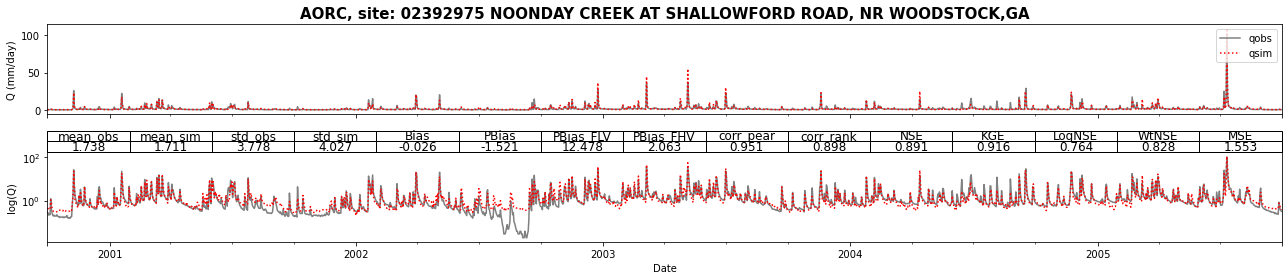

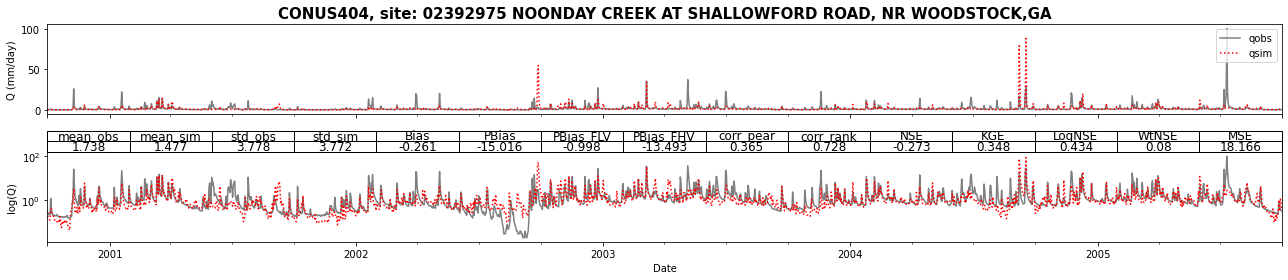

In [13]:
s = '02392975'

## First plot: AORC
df = LSTM_aorc_valid[s]
verif = my_verif(df.qobs, df.qsim).iloc[:, :15]
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(18,4))
df.plot.line(ax=axes[0], use_index=True, sharex=True,  y=['qobs','qsim'], color={"qobs":"gray", 'qsim':'red'}, style=['-',':'], logy=False).legend(loc='upper right')
df.plot.line(ax=axes[1], y=['qobs','qsim'], color={"qobs":"gray", 'qsim':'red'}, style=['-',':'], logy=True, legend=False)
axes[0].set_ylabel('Q (mm/day)')
axes[1].set_ylabel('log(Q)')
axes[1].set_xlabel('Date')
axes[0].set_title('AORC, site: '+s+' '+usgs_short.station_nm.loc[s], fontsize=15, fontweight='bold')
# axes[3].axis('off')

tbl = axes[1].table(cellText=verif.values.round(3), colLabels=list(verif.columns), loc='top', cellLoc='center' ) #pd.plotting.table(ax=axes[3], data=verif.iloc[:, :10], fontsize=47)
tbl.auto_set_font_size(False)
tbl.set_fontsize(12)
plt.tight_layout()

## Second plot: C404
df = LSTM_c404_valid[s]
verif = my_verif(df.qobs, df.qsim).iloc[:, :15]
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(18,4))
df.plot.line(ax=axes[0], use_index=True, sharex=True,  y=['qobs','qsim'], color={"qobs":"gray", 'qsim':'red'}, style=['-',':'], logy=False).legend(loc='upper right')
df.plot.line(ax=axes[1], y=['qobs','qsim'], color={"qobs":"gray", 'qsim':'red'}, style=['-',':'], logy=True, legend=False)
axes[0].set_ylabel('Q (mm/day)')
axes[1].set_ylabel('log(Q)')
axes[1].set_xlabel('Date')
axes[0].set_title('CONUS404, site: '+s+' '+usgs_short.station_nm.loc[s], fontsize=15, fontweight='bold')
# axes[3].axis('off')

tbl = axes[1].table(cellText=verif.values.round(3), colLabels=list(verif.columns), loc='top', cellLoc='center' ) #pd.plotting.table(ax=axes[3], data=verif.iloc[:, :10], fontsize=47)
tbl.auto_set_font_size(False)
tbl.set_fontsize(12)
plt.tight_layout()

In [127]:
verif.iloc[:, :10]

mean_obs  mean_sim   std_obs   std_sim    Bias  Bias_perc  corr_pear  \
0  2.701746  2.461445  5.144389  4.890418 -0.2403  -8.894261    0.94638   

   corr_rank       NSE       KGE  
0   0.980782  0.893435  0.885008